# Лабораторна робота №9. ІАД

**Тема:** Створення власного набору даних та розробка моделі бінарної класифікації за допомогою згорткової нейронної мережі (CNN).

**Виконав:** Гульчак Дар'я МІТ-31

**Мета:**
1. Створити та підготувати власний набір даних для задачі бінарної класифікації (Піца проти Бургерів).
2. Розробити та навчити модель згорткової нейронної мережі (CNN).
3. Здійснити оцінювання моделі за допомогою метрик accuracy, precision, recall, F1-score.

**Об'єкт дослідження:** Зображення піци та бургерів.

In [1]:
%pip install tensorflow matplotlib scikit-learn numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Імпорт бібліотек та налаштування середовища
На цьому кроці ми підключаємо необхідні бібліотеки:
* **TensorFlow/Keras:** для створення нейронної мережі.
* **ImageDataGenerator:** для завантаження та обробки зображень.
* **Matplotlib:** для побудови графіків.
* **Sklearn:** для детального звіту про класифікацію.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Бібліотеки успішно завантажено.")

Бібліотеки успішно завантажено.


## 2. Завантаження та попередня обробка даних
Ми використовуємо `ImageDataGenerator` для двох цілей:
1. **Нормалізація:** Значення пікселів (0-255) перетворюються у діапазон (0-1).
2. **Аугментація (тільки для тренування):** Штучне збільшення кількості даних шляхом поворотів, зсувів та віддзеркалень. Це допомагає уникнути перенавчання.

In [3]:
# 1. Генератор для навчання з аугментацією
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Нормалізація
    rotation_range=20,          # Поворот зображення до 20 градусів
    width_shift_range=0.2,      # Зсув по горизонталі
    height_shift_range=0.2,     # Зсув по вертикалі
    shear_range=0.2,            # Викривлення
    zoom_range=0.2,             # Наближення
    horizontal_flip=True,       # Дзеркальне відображення
    fill_mode='nearest'
)

# 2. Генератор для тестування (тільки нормалізація)
test_datagen = ImageDataGenerator(rescale=1./255)

# Завантаження даних з папок
print("--- Завантаження тренувальних даних ---")
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print("\n--- Завантаження тестових даних ---")
test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Не перемішуємо для коректної оцінки в кінці
)

# Виведемо індекси класів
print(f"\nВизначені класи: {train_data.class_indices}")

--- Завантаження тренувальних даних ---
Found 91 images belonging to 2 classes.



--- Завантаження тестових даних ---
Found 40 images belonging to 2 classes.

Визначені класи: {'burger': 0, 'pizza': 1}


## 3. Побудова архітектури CNN
Створюємо модель типу `Sequential`. Архітектура складається з:
* **Conv2D шарів:** Виділяють ознаки (контури, текстури, форми) з зображення.
* **MaxPooling2D:** Зменшують розмірність зображення, залишаючи найважливіші ознаки.
* **Flatten:** Перетворює двовимірні матриці у одновимірний вектор.
* **Dense:** Повнозв'язні шари для фінальної класифікації.
* **Dropout:** Вимикає частину нейронів для регуляризації.

In [4]:
model = models.Sequential([
    # Перший згортковий блок
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    # Другий згортковий блок
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Третій згортковий блок
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Класифікатор
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),                  # Регуляризація
    layers.Dense(1, activation='sigmoid') # Вихідний шар (0 або 1)
])

# Компіляція моделі
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\HP Victus\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Навчання моделі
Запускаємо процес навчання на 10 епох. Модель буде навчатися на `train_data` і перевіряти свою якість на `test_data` після кожної епохи.

In [5]:
EPOCHS = 10

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4725 - loss: 1.6402 - val_accuracy: 0.4500 - val_loss: 0.8102
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5055 - loss: 0.8989 - val_accuracy: 0.5000 - val_loss: 1.5463
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5495 - loss: 0.6562 - val_accuracy: 0.3750 - val_loss: 1.1622
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5824 - loss: 0.6298 - val_accuracy: 0.2250 - val_loss: 1.5012
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6923 - loss: 0.5923 - val_accuracy: 0.3750 - val_loss: 3.2009
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6923 - loss: 0.6124 - val_accuracy: 0.2500 - val_loss: 2.1347
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6923 - loss: 0.5719 - val_accuracy: 0.2750 - val_loss: 2.6959
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7143 - loss: 0.5529 - val_accuracy: 0.3500 - val_loss: 3.9933
Epoch 9/10
3/3 ━

## 5. Візуалізація результатів
Побудуємо графіки точності (Accuracy) та втрат (Loss) для тренувального та валідаційного наборів даних. 
Це дозволить побачити, чи є перенавчання (якщо графіки сильно розходяться).

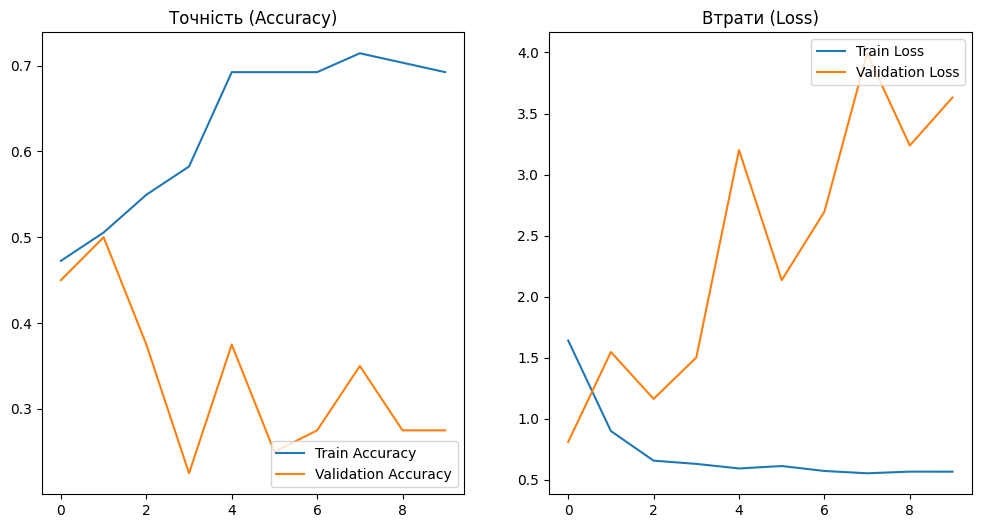

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Точність (Accuracy)')

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')
plt.show()

## 6. Оцінка якості моделі
Розрахуємо фінальні метрики якості:
* **Precision:** Точність визначення класу.
* **Recall:** Повнота (яку частину об'єктів класу ми знайшли).
* **F1-score:** Гармонійне середнє між Precision та Recall.
Також виведемо матрицю помилок.

In [7]:
# Отримання прогнозів
test_data.reset()
predictions = model.predict(test_data, steps=len(test_data))
y_pred = (predictions > 0.5).astype("int32")
y_true = test_data.classes

# Отримання назв класів
class_labels = list(test_data.class_indices.keys())

# Вивід звіту класифікації
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Матриця помилок
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      burger       0.35      0.55      0.43        20
       pizza       0.00      0.00      0.00        20

    accuracy                           0.28        40
   macro avg       0.18      0.28      0.22        40
weighted avg       0.18      0.28      0.22        40


--- Confusion Matrix ---
[[11  9]
 [20  0]]
